## Light Echo and Star Detection

In this tutorial, we will use the VGG16 AI model to detect light echoes and stars in images. We will train the model on a sample dataset and explore how the model makes predictions by analyzing the feature maps.

Exercises

- Load the [Dataset](#Dataset)

- Train the [Model](#Model)

- Make predictions and evaulation

- Saliency map

- Explore the [feature maps](#Feature-maps)

- tSNE scatter plot in feature space

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)


Mounted at /drive


In [ ]:
cd '/drive/MyDrive/04_le/'

/drive/MyDrive/ztf_demo


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary

from sklearn.manifold import TSNE


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### dataset


In [ ]:
image_trans = transforms.Compose([transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

image_dataset = datasets.ImageFolder(root='./dataset/vgg/train1/', transform=image_trans)
dataloader = DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=2)

image_dataset_test = datasets.ImageFolder(root='./dataset/vgg/test1/', transform=image_trans)
dataloader_test = DataLoader(image_dataset_test, batch_size=4, shuffle=True, num_workers=2)


In [ ]:
image_dataset.classes
#image_dataset.__dict__

['LE', 'star']

In [ ]:
images, labels = next( iter(dataloader) )

In [ ]:
images.shape, labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [ ]:
labels

tensor([0, 1, 1, 0])

In [ ]:
def plot_batch(images, labels):
    fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
    axs = axs.flatten()

    for i in range(4):
        axs[i].imshow(images[i, 0, :, :], origin='lower', cmap='gray', interpolation=None);
        axs[i].set_title(f'label={labels[i]}')
    return fig


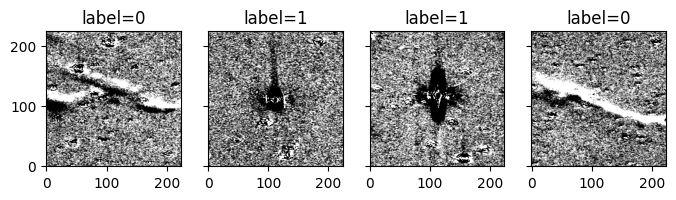

In [ ]:
plot_batch(images, labels);

### train the model

Exercise: load the pre-trained vgg16 model, and train on the dataset

In [246]:
# Load the pre-trained VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [247]:
# modify the last layer in classifier to match number of classes, 2 for our case

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

In [248]:
model = model.to(device)


In [253]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [254]:
# train the model
num_epochs = 20

loss_run = []

model.train()
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # input shape [4 batchsize, 3, 224, 224], labels shape [4]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_run.append(loss.item())
        print(f'epoch {epoch}, loss {loss.item()}')


epoch 0, loss 0.5011109113693237
epoch 0, loss 0.6926753520965576
epoch 1, loss 0.529155969619751
epoch 1, loss 0.3360704779624939
epoch 2, loss 0.356262743473053
epoch 2, loss 0.26286745071411133
epoch 3, loss 0.25042831897735596
epoch 3, loss 0.3766152262687683
epoch 4, loss 0.2504756450653076
epoch 4, loss 0.15037623047828674
epoch 5, loss 0.19245292246341705
epoch 5, loss 0.20564478635787964
epoch 6, loss 0.04493211582303047
epoch 6, loss 0.15982073545455933
epoch 7, loss 0.07867366820573807
epoch 7, loss 0.04863918945193291
epoch 8, loss 0.10403809696435928
epoch 8, loss 0.0508243590593338
epoch 9, loss 0.039482541382312775
epoch 9, loss 0.01774248667061329
epoch 10, loss 0.017090240493416786
epoch 10, loss 0.011164287105202675
epoch 11, loss 0.007981028407812119
epoch 11, loss 0.02188916690647602
epoch 12, loss 0.010594786144793034
epoch 12, loss 0.00724567798897624
epoch 13, loss 0.0071492874994874
epoch 13, loss 0.013000383973121643
epoch 14, loss 0.009009655565023422
epoch 14,

Text(0, 0.5, 'loss')

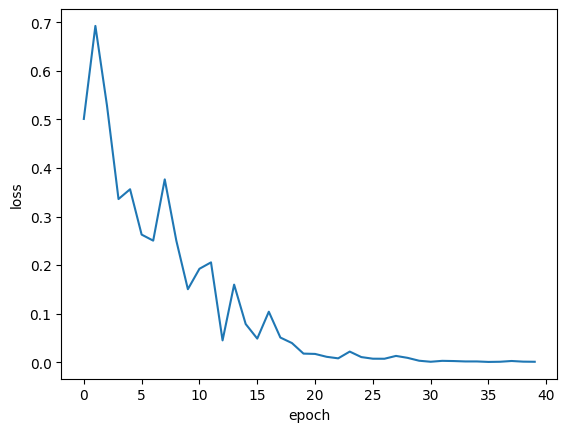

In [255]:
plt.plot(loss_run)
plt.xlabel('epoch')
plt.ylabel('loss')

### make prediction

In [294]:
images, labels = next(iter(dataloader_test))


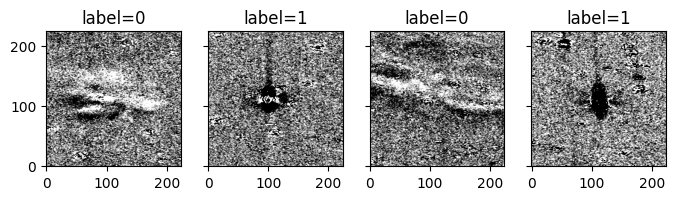

In [295]:
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
axs = axs.flatten()

for i in range(4):
    axs[i].imshow(images[i, 0, :, :], origin='lower', cmap='gray', interpolation=None);
    axs[i].set_title(f'label={labels[i]}')

In [283]:
model.eval();

In [284]:
images = images.to(device)

In [285]:
outputs = model(images).softmax(dim=1)
outputs

tensor([[0.9932, 0.0068],
        [0.0033, 0.9967],
        [0.9815, 0.0185],
        [0.9990, 0.0010]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [286]:
_, preds = torch.max(outputs, 1)
preds

tensor([0, 1, 0, 0], device='cuda:0')

In [287]:
labels

tensor([0, 1, 0, 0])

Exercise: calculate the accuracy on training and test set


In [ ]:
#

Exercise: run a sliding window detection on larger images in folder rcnn/tiles/, generate a heatmap for the class output

In [ ]:
#

### saliency map

A saliency map is a visualization technique used in deep learning and computer vision to highlight the regions of an image that are most important for a model's predictions. It shows which parts of the input image have the greatest influence on the output of the model.

Saliency maps often use gradients to determine the importance of each pixel. The gradients of the output class score with respect to the input image are computed. These gradients indicate how much a small change in each pixel value would affect the class score.


initial with input data


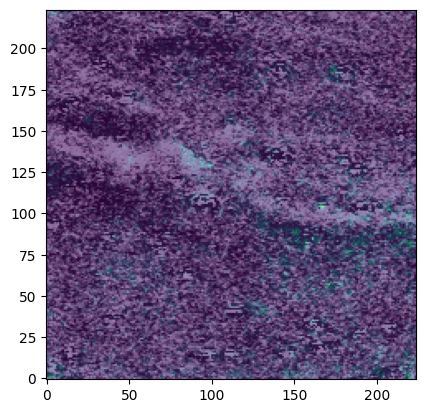

In [299]:
# create an image that requires_grad
input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

img_idx = 2
# use one of image as input
input_data = images[img_idx].data
if input_data!=None:
    print('initial with input data')
    input_image.data = input_data.to(device).unsqueeze(0)

target_class = 0
output = model(input_image)
score = output[0, target_class]
model.zero_grad()
score.backward(retain_graph=True)
saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().numpy()

plt.imshow(images.cpu()[img_idx, 0, :, :], origin='lower', cmap='gray');
plt.imshow(saliency, origin='lower', alpha=0.6);

### Explore features


The method of visualizing feature maps by optimizing the input image involves generating an image that maximizes the activation of a specific layer or neuron within a neural network. This technique helps us understand what patterns or features a particular part of the network is sensitive to.

Steps

- Select a target layer
- Use the forward hook to capture activations
- Initial a random image that require grads
- Adjust the input image in the direction of the gradients using an optimizer
- Visualize the optimized image

In [300]:
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [315]:
# Select a layer

layer_idx = 23

model.features[layer_idx]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [306]:
def get_layer_output(model, input_image, layer_index=29,):
    """get the output from a layer
    input_image: shape [batch, 3, 244, 244]"""

    input_image = input_image.to(device)
    # Dictionary to store the output from the specified layer
    outputs = {}

    def hook_fn(module, input, output):
        """register to layer, run during forward"""
        outputs["layer_output"] = output

    # Register the hook
    hook = model.features[layer_index].register_forward_hook(hook_fn)

    _ = model(input_image)  # Forward pass to get the activations

    # Remove the hook after optimization
    hook.remove()

    layer_output = outputs["layer_output"].detach().cpu().numpy()
    return layer_output

In [307]:
def get_featuremap(model=model,
                   input_data=None,
                   layer_index=29, feature_map_index=0, num_iterations = 100, lr=0.01):
    """optimize an random input for a specific layer to get the high activations,
    """

    # Step 1: Create a random image
    # Initialize a random image tensor with required shape and allow gradient computation
    input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

    if input_data!=None:
        print('initial with input data')
        input_image.data = input_data.to(device).unsqueeze(0)

    # Step 2: Load the pre-trained VGG16 model in evaluation mode

    # Step 3: Register a forward hook to access the features of a specific layer (e.g., layer 10)
    #layer_index = 29
    #feature_map_index = 12  # Specify the feature map index you want to maximize

    # Dictionary to store the output from the specified layer
    outputs = {}

    def hook_fn(module, input, output):
        """register to layer, run during forward"""
        outputs["layer_output"] = output

    # Register the hook
    hook = model.features[layer_index].register_forward_hook(hook_fn)

    # Step 4: Define the optimizer and the loss function
    # Use an optimizer to change the pixel values of the input image
    optimizer = torch.optim.Adam([input_image], lr=lr)

    # Number of iterations for optimization
    #num_iterations = 100

    # Optimization loop
    for i in range(num_iterations):
        optimizer.zero_grad()  # Clear previous gradients

        _ = model(input_image)  # Forward pass to get the activations

        # Get the activation of the specific feature map
        layer_output = outputs["layer_output"]
        feature_map_activation = layer_output[0, feature_map_index]  # Accessing the desired feature map

        # Calculate the mean activation of the feature map
        loss = - torch.mean(feature_map_activation) # Negate to maximize

        # Perform backpropagation and optimize the image
        loss.backward()
        optimizer.step()

        #print('grad', type(input_image.grad))

        # Clip the values of the image tensor to keep them in the valid range
        with torch.no_grad():
            input_image.clamp_(0, 1)

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    # Remove the hook after optimization
    hook.remove()

    # Step 5: Display the optimized image
    # Convert the optimized image tensor to a format suitable for displaying
    optimized_image = input_image.detach().cpu().squeeze()  # Remove batch dimension and move to CPU
    optimized_image = optimized_image.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
    optimized_image = optimized_image.numpy()
    return optimized_image, input_image


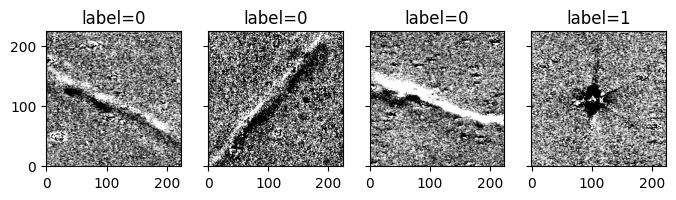

In [308]:
img, labels = next(iter(dataloader))

plot_batch(img, labels);

In [309]:
layer_output = get_layer_output(model, img, layer_index=29)
layer_output.shape

(4, 512, 14, 14)

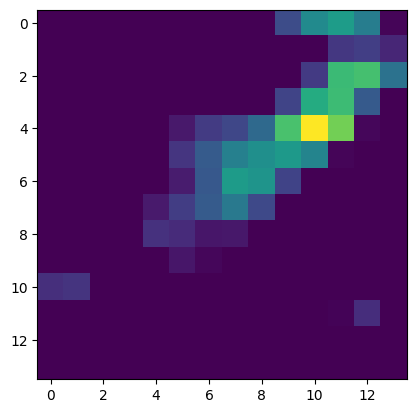

In [311]:
plt.imshow(layer_output[0, 16, :, :],)

In [312]:
layer_output_mean = layer_output.mean(axis=3).mean(axis=2)

In [313]:
layer_output_mean.shape

(4, 512)

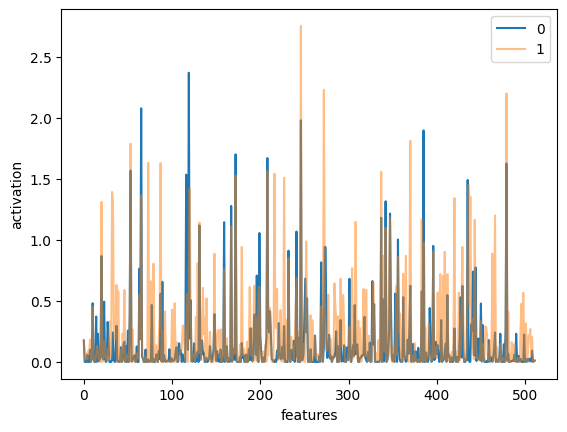

In [361]:
# activation values in feature space
plt.plot(layer_output_mean[0], label=f'label={labels.numpy()[0]}')
#plt.plot(layer_output_mean[1], alpha=0.5,)
#plt.plot(layer_output_mean[2], alpha=0.5)
plt.plot(layer_output_mean[3], alpha=0.5, label=f'label={labels.numpy()[3]}')

plt.xlabel('features')
plt.ylabel('activation')

plt.legend()

In [317]:
np.argsort(layer_output_mean[1])[::-1][:5]

array([119, 385, 342, 435, 208])

In [318]:
np.argsort(layer_output_mean[0])[::-1][:5]

array([119,  65, 246, 385, 172])

In [319]:
layer_output_mean[0] [ np.argsort(layer_output_mean[0])[::-1][:5] ]

array([2.371737 , 2.0795276, 1.9810079, 1.8983423, 1.7020944],
      dtype=float32)

In [329]:
fmaps = {}
feature_list = [119,  65, 246, 385, 172]
for i in feature_list:
    #idx = 303
    optimized_image, input_image = get_featuremap(model=model,
                                     #input_data=img[0].data,
                                     layer_index=layer_idx, feature_map_index=i,
                                     num_iterations=300, lr=0.05)
    fmaps[i] = optimized_image

Iteration 0, Loss: -0.04663071408867836
Iteration 10, Loss: -11.070708274841309
Iteration 20, Loss: -31.30217742919922
Iteration 30, Loss: -50.600406646728516
Iteration 40, Loss: -65.66112518310547
Iteration 50, Loss: -76.64057159423828
Iteration 60, Loss: -85.11878204345703
Iteration 70, Loss: -91.40043640136719
Iteration 80, Loss: -96.02141571044922
Iteration 90, Loss: -99.43424224853516
Iteration 100, Loss: -102.17298889160156
Iteration 110, Loss: -104.44959259033203
Iteration 120, Loss: -106.4328842163086
Iteration 130, Loss: -108.10227966308594
Iteration 140, Loss: -109.60237121582031
Iteration 150, Loss: -110.87109375
Iteration 160, Loss: -111.99322509765625
Iteration 170, Loss: -112.9918441772461
Iteration 180, Loss: -113.88988494873047
Iteration 190, Loss: -114.69308471679688
Iteration 200, Loss: -115.44241333007812
Iteration 210, Loss: -116.11087036132812
Iteration 220, Loss: -116.75436401367188
Iteration 230, Loss: -117.3808364868164
Iteration 240, Loss: -117.95629119873047
I

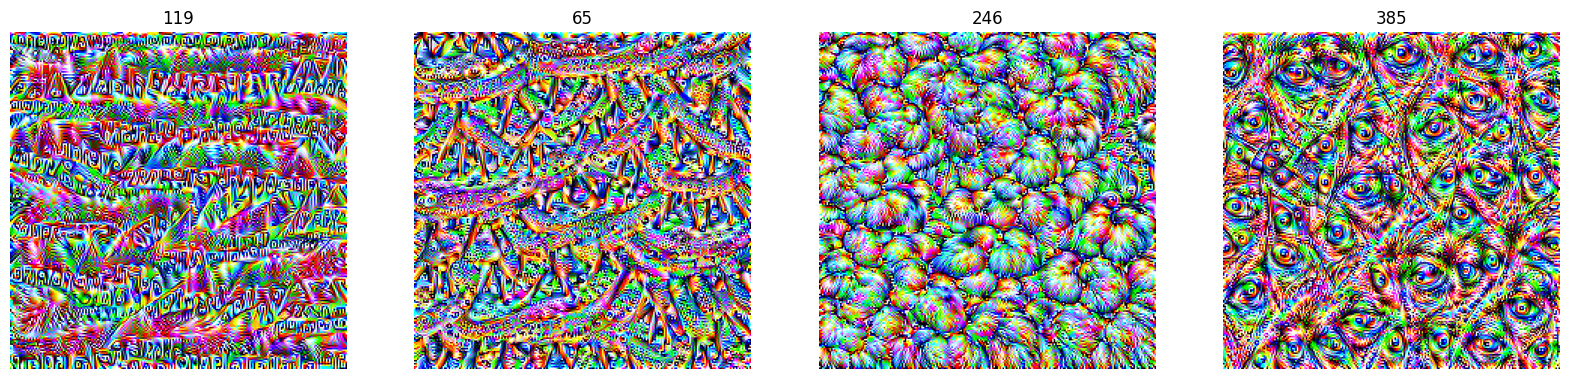

In [330]:

n = len(feature_list)
fig, axs = plt.subplots(1, n-1, figsize=(20, 5))

for i in range(n-1):
    axs[i].imshow(fmaps[ feature_list[i] ])
    axs[i].set_title(feature_list[i] )
    axs[i].axis('off')

Exercise: generate feature plots for several early and later layers in VGG16, how do stars and differ in feature space?

In [ ]:
#

#### TSNE
t-SNE is a dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is especially useful for exploring the high-dimensional datasets and understanding how data points relate to each other.



In [347]:
Colors = {0:'tab:red', 1:'tab:blue'}

In [332]:
layer_output_mean.shape

(4, 512)

In [333]:
tsne = TSNE(n_components=2, random_state=0, perplexity=3)


In [335]:
tsne_results = tsne.fit_transform(layer_output_mean)


Text(0, 0.5, 'feature 2')

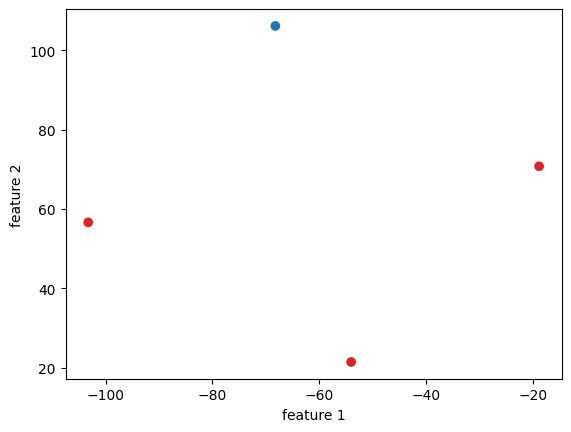

In [354]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            color=[Colors[i] for i in labels.numpy()])

plt.xlabel('feature 1')
plt.ylabel('feature 2')

Exercise: plot for all images in train and test sets, does this reveal any clustering patterns for LE and star images?

In [ ]:
#

Exercise: try another model from https://pytorch.org/vision/0.9/models.html, are there differences in features and performance?

In [ ]:
#